Import modules and read + split input df

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, roc_curve
from sklearn.metrics import auc, roc_auc_score
from sklearn.model_selection import train_test_split
import torch
import tqdm

In [2]:
## Reading dataset

full_df = pd.read_json("data/raw/pp_context.json.gz", compression='infer', lines=True)
full_df.head()

,pp_sent,spoiler,pp_prev,pp_next
0,special book,0,,start slow first third middl third start get i...
1,start slow first third middl third start get i...,0,special book,love good scienc fiction push think thing go
2,love good scienc fiction push think thing go,0,start slow first third middl third start get i...,2015 hugo winner translat origin chines made i...
3,2015 hugo winner translat origin chines made i...,0,love good scienc fiction push think thing go,instanc intermix chines revolutionari histori ...
4,instanc intermix chines revolutionari histori ...,0,2015 hugo winner translat origin chines made i...,book scienc alien


In [3]:
full_df, validate_df = full_df.iloc[100000:], full_df.iloc[:100000]
#validate_df = full_df.iloc[range(1, len(full_df), 2)]
#full_df = full_df.iloc[range(0, len(full_df), 2)]

len(full_df), len(validate_df)

(2357349, 100000)

Generate vocab and embeddings inplace of df sents

In [4]:
vocab = set()
word_to_id = dict()
id_to_word = dict()
word_to_count = dict()
vocab_size = 1

In [5]:
max_len = 500 # placeholder value

In [6]:
cols = ['pp_sent'] # Use if you want vocab to include just review text

In [7]:
def generate_vocab(cols):
    global vocab_size, vocab
    global word_to_id, id_to_word, word_to_count
    global full_df
    global df_mini
    cleaned_reviews_ids = []
    cleaned_summaries_ids = []
    
    for index, row in tqdm.tqdm(full_df.iterrows(), total=full_df.shape[0]):
        for c in cols:   
            s2n = []
            split = str(row[c]).split()
            
            for word in split:
                if word not in vocab:
                    vocab.add(word)
                    word_to_id[word] = vocab_size
                    # word_to_count[word] = 1
                    s2n.append(vocab_size)
                    id_to_word[vocab_size] = word
                    vocab_size += 1   
                else:
                    # word_to_count[word] += 1
                    s2n.append(word_to_id[word])
            full_df.at[index, c] = s2n

   

In [8]:
generate_vocab(cols)

100%|██████████| 2357349/2357349 [02:25<00:00, 16179.50it/s]


In [9]:
print(len(vocab))

187227


Split df in Train, Test, Val Split

In [10]:
X_train = []
y_train = []
X_test = []
y_test = []
X_val = []
y_val = []

In [11]:
full_df['spoiler'] = full_df['spoiler'].fillna(0)
full_df['spoiler'].isna().sum()

0

In [12]:
def split_data(cols):
    
    global X_train, y_train
    global X_test, y_test
    global X_val, y_val
    global X_train_movie_ids, X_test_movie_ids, X_val_movie_ids
    
    train_ratio = 0.8 # Split into training and validation
    test_ratio = 0.85 # Split into training and testing
    
    X = list(full_df['pp_sent'])
    y = list(full_df['spoiler'].astype(int))
    
    X_rem, X_test, y_rem, y_test = train_test_split(X, y, train_size=test_ratio)
    X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, train_size=train_ratio)
    
    
    # X_train = [X_train[c] for c in cols]
    # X_val = [X_val[c] for c in cols]
    # X_test = [X_test[c] for c in cols]
    
    # y_train = y_train.values
    # y_test = y_test.values
    # y_val = y_val.values

In [13]:
split_data(cols)

In [14]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

1602996 1602996 353603 353603


In [15]:
def pad_sequences(X_list):
    
    X_padded = torch.nn.utils.rnn.pad_sequence([torch.as_tensor(l) for l in X_list]).type(torch.LongTensor) # padding the sequences with 0
    X_mask   = torch.nn.utils.rnn.pad_sequence([torch.as_tensor([1.0] * len(l)) for l in X_list]).type(torch.FloatTensor)
    
    return X_padded, X_mask

In [16]:
# Takes about 20 seconds to run
X_train = pad_sequences(X_train)[0]

In [17]:
X_test = pad_sequences(X_test)[0]
X_val = pad_sequences(X_val)[0]

In [18]:
# y_train = torch.Tensor(y_train)
# y_test = torch.Tensor(y_test)
# y_val = torch.Tensor(y_val)

In [19]:
X_train.shape # [max_sentence_len, num_data_points]

torch.Size([122, 1602996])

In [20]:
X_train = X_train.T
X_test = X_test.T
X_val = X_val.T

print(X_train.shape, X_test.shape, X_val.shape)

torch.Size([1602996, 122]) torch.Size([353603, 57]) torch.Size([400750, 67])


## Spoiler Net

Read pretrained word vectors

In [21]:
!pip install gensim
import gensim
weights = gensim.models.KeyedVectors.load_word2vec_format('logdir/word2vec_combined.wv', binary=False)
weights = torch.FloatTensor(weights.vectors)

     |████████████████████████████████| 24.1 MB 17.3 MB/s eta 0:00:01


The actual architecture of the net, stored in a class

In [22]:
class SpoilerNet(torch.nn.Module):

    def __init__(self,vocab_size, emb_dim = 150, hid_dim = 50):
        super(SpoilerNet, self).__init__()

        # initialize parameters
        self.EMB_DIM = emb_dim
        self.DIM_HIDDEN = hid_dim
        self.VOCAB_SIZE = vocab_size

        # initialize layers

        self.embedding = torch.nn.Embedding.from_pretrained(weights, freeze=False)
        self.word_encoder = torch.nn.GRU(self.EMB_DIM, self.DIM_HIDDEN, bidirectional = True, batch_first = True) 

        ## for word attention ##
        self.mu = torch.nn.Linear(self.DIM_HIDDEN, self.DIM_HIDDEN)
        self.tanh = torch.nn.Tanh()
        self.v = torch.nn.Linear(self.DIM_HIDDEN, self.DIM_HIDDEN, bias = False)
        self.alpha = torch.nn.Softmax(dim = 1) 


        # create sentence encoder
        self.sentence_encoder = torch.nn.GRU(self.DIM_HIDDEN, self.DIM_HIDDEN, bidirectional = True, batch_first=True)
        self.dropout = torch.nn.Dropout(0.5) # according to paper 
        self.output = torch.nn.Linear(self.DIM_HIDDEN, 2)
        self.activation = torch.nn.Sigmoid()


    def forward(self, X):
        text_embeddings = self.embedding(X) # generating text embeddings

        word_enc_out, word_hn = self.word_encoder(text_embeddings) # word encoder outputs

        h_w = word_enc_out[:, :, :self.DIM_HIDDEN] + word_enc_out[:, :, self.DIM_HIDDEN:] # adding output represen of both GRUs


        # applying word attention

        mu_w = self.tanh(self.mu(h_w))

        v_out = self.v(mu_w)

        alpha_w = self.alpha(v_out)

        # input for sentence encoder

        v_s = torch.sum(alpha_w * h_w, dim = 1)
        vectorized_sentences = [v_s]
        stacked_vectorized_sentences = torch.stack(vectorized_sentences,dim=1)

        sent_enc_out, _ = self.sentence_encoder(stacked_vectorized_sentences) # sentence encoder outputs
        h_s = sent_enc_out[:,:, :self.DIM_HIDDEN] + sent_enc_out[:,:, self.DIM_HIDDEN:] # adding output represen of both GRUs
        
        drop = self.dropout(h_s)
        out = self.output(drop) # unnormalized class scores (batchSize, 2)
        return out     
  

The function for predicting

In [23]:
def predict(model, x, y):
    y_pred = []
    y_probs = []
    num_correct = 0
    x = x.cuda()
    sigmoid = torch.nn.Sigmoid()
    for i in tqdm.tqdm(range(len(x))):
        probs = sigmoid(model.forward(x[i].unsqueeze(0)))
        #print(probs)
        pred = torch.argmax(probs)
        y_pred.append(pred.item())
        y_probs.append(probs[0][0][1].item())

        if pred == y[i]:
            num_correct += 1
    print("ROC_AUC: %s" % roc_auc_score(y, y_probs))
    return y_probs

Set training parameters according to paper and train for x epochs

In [24]:
batchSize = 128 

model = SpoilerNet(vocab_size).cuda()

loss_func = torch.nn.CrossEntropyLoss()

y_train = torch.LongTensor(y_train)
clip = 50.0

In [25]:
LEARNING_RATE = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
NUM_EPOCHS = 1
NUM_BATCHES = len(range(0, X_train.shape[0], batchSize))

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0
    for i in tqdm.tqdm(range(0, X_train.shape[0], batchSize)):
        optimizer.zero_grad()
        s = i
        e = i + batchSize
        if i + batchSize >= X_train.shape[0]:
            e = X_train.shape[0]

        X_batch = X_train[s:e, :]
        Y_batch = y_train[s:e]
        output = model.forward(X_batch.cuda())
        loss = loss_func(output.squeeze(), Y_batch.cuda())
        total_loss += loss.item()
        loss.backward() 
        _ = torch.nn.utils.clip_grad_norm_(model.parameters(), clip) # gradient clipping
        optimizer.step()
    model.eval()
    print("Loss at epoch", epoch,":", total_loss/NUM_BATCHES, end = '\t')
    #_ = predict(model, X_val, y_val)

100%|██████████| 12524/12524 [04:25<00:00, 47.11it/s]

Loss at epoch 0 : 0.12511737762270086	

Evaluate model by predicting testset

In [29]:
model.eval()
y_pred = predict(model, X_test, y_test)

100%|██████████| 353603/353603 [10:02<00:00, 587.15it/s]


ROC_AUC: 0.7512744672000229


## Results

With the trained model, predict the subcorpus and store the resluts to ue it in TABLEARN

In [32]:
validate_df = pd.read_csv("data/res/Context_Input.csv")

In [33]:
y = list(validate_df['spoiler'].astype(int))
y = torch.LongTensor(y)
cs = ["pp_sent", "next_sent", "prev_sent"]
data = {"spoiler":y}
for c in cs:
    for index, row in tqdm.tqdm(validate_df.iterrows(), total=validate_df.shape[0]):  
        s2n = []
        split = str(row[c]).split()

        for word in split:
            if word not in word_to_id.keys():
                continue
            s2n.append(word_to_id[word])
        validate_df.at[index, c] = s2n
    
    X = list(validate_df[c])
    X = pad_sequences(X)[0].T
    probs = predict(model, X, y)
    data[c] = probs
save_df = pd.DataFrame(data)
save_df.shape

100%|██████████| 376331/376331 [18:35<00:00, 337.24it/s]


ROC_AUC: 0.7468019013992163


100%|██████████| 376331/376331 [10:42<00:00, 585.33it/s]


ROC_AUC: 0.6888632912201506


100%|██████████| 376331/376331 [10:44<00:00, 583.58it/s]


ROC_AUC: 0.711507732511432


(376331, 4)

In [ ]:
save_df.to_csv("fastai_context.csv")

In [27]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image, display_svg, SVG

In [121]:
BASELINE.head()

,Unnamed: 0,sent,spoiler,book_bias,user_bias,position,specificity
0,0,This is a special book.,0,0.096429,0.143149,0.047619,0.028055
1,1,"It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind.",0,0.096429,0.143149,0.095238,0.029345
2,2,This is what I love about good science fiction - it pushes your thinking about where things can go.,0,0.096429,0.143149,0.142857,0.022951
3,3,"It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I've read.",0,0.096429,0.143149,0.190476,0.024558
4,4,"For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being ""reactionaries"", etc.",0,0.096429,0.143149,0.238095,0.026657


Also create context predictions and evaluate the model on the whole goodreads corpus

In [28]:
BASELINE = pd.read_csv('data/res/baseline_spoilernet.csv', low_memory=False).iloc[:100000]
save_df["spoiler"] = save_df["spoiler"].astype('category')
save_df["book_bias"] = BASELINE["book_bias"].fillna(0)
save_df["user_bias"] = BASELINE["user_bias"].fillna(0)
save_df["position"] = BASELINE["position"].fillna(0)
save_df["specificity"] = BASELINE["specificity"].fillna(0)

X_train, X_test = train_test_split(save_df.index, train_size=0.7)
X_valid, X_test = train_test_split(X_test, train_size=0.5)

In [43]:
cont = ["book_bias", "user_bias", "position", "specificity"] #["pp_sent", "pp_prev", "pp_next", 
to = TabularPandas(save_df, procs=[FillMissing], cont_names=cont, y_names="spoiler", splits=[list(X_train), list(X_valid)])
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
dls = to.dataloaders(1024)
len(to.train),len(to.valid)
save_df.head()

,spoiler,pp_sent,pp_prev,pp_next,book_bias,user_bias,position,specificity
0,0,0.052614,0.154097,0.046008,0.096429,0.143149,0.047619,0.028055
1,0,0.046008,0.052614,0.075687,0.096429,0.143149,0.095238,0.029345
2,0,0.075687,0.046008,0.031384,0.096429,0.143149,0.142857,0.022951
3,0,0.031384,0.075687,0.160323,0.096429,0.143149,0.190476,0.024558
4,0,0.160323,0.031384,0.086760,0.096429,0.143149,0.238095,0.026657


In [44]:
class_count_df = save_df.iloc[:].groupby("spoiler").count()

n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]

w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)

# Important: Convert Weights To Float Tensor
class_weights=torch.FloatTensor([w_0, w_1])
class_weights

tensor([ 0.5127, 20.1532])

SuggestedLRs(valley=0.001737800776027143)

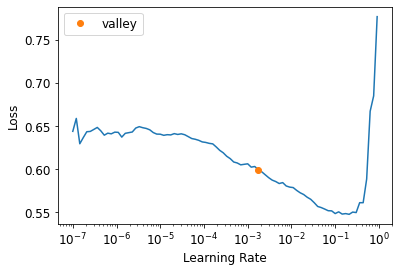

In [45]:
roc = RocAucBinary()
loss_func = CrossEntropyLossFlat(weight=class_weights) #
learn = tabular_learner(dls, loss_func=loss_func, metrics=roc)

learn.lr_find()

In [47]:
learn.fit_one_cycle(10, 0.001737800776027143)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.532328,0.524022,0.881480,00:00
1,0.486937,0.453811,0.888663,00:00
2,0.455565,0.430127,0.889557,00:00
3,0.436759,0.424665,0.889590,00:00
4,0.434340,0.422844,0.889048,00:01
5,0.427503,0.413976,0.892910,00:00
6,0.425970,0.417887,0.894153,00:01
7,0.420084,0.409045,0.894791,00:01
8,0.413746,0.409623,0.894574,00:01
9,0.407625,0.409342,0.894824,00:00


In [48]:
dl_test = learn.dls.test_dl(save_df.iloc[list(X_test)], bs=1024) # apply transforms
preds,  _ = learn.get_preds(dl=dl_test) # get prediction
trues = []
npreds = []
for i in range(len(preds)):
    npreds.append(preds[i][1].item())
    trues.append(save_df.iloc[list(X_test)]["spoiler"].values[i])
from sklearn.metrics import roc_auc_score
roc_auc_score(trues, npreds)

0.872031908831909

In [49]:
new_df = pd.read_csv("data/raw/sent_sims_clean.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'models/sent_sims_clean.csv'

In [28]:
c = "pp_sent"
for index, row in tqdm.tqdm(new_df.iterrows(), total=new_df.shape[0]):  
    s2n = []
    split = str(row[c]).split()

    for word in split:
        if word not in word_to_id.keys():
            continue
        s2n.append(word_to_id[word])
    new_df.at[index, c] = s2n

100%|██████████| 376331/376331 [00:22<00:00, 16690.55it/s]


In [36]:
X = list(new_df['pp_sent'])
y = list(new_df['spoiler'].astype(int))
X = pad_sequences(X)[0].T
y = torch.LongTensor(y)

In [39]:
probs = predict(model, X, y)

ROC_AUC: 0.7744750830822102


In [41]:
y.shape, X.shape, len(probs)

(torch.Size([376331]), torch.Size([376331, 131]), 376331)

In [42]:
sdf = pd.DataFrame({"spoilernet":probs})
sdf.to_csv("spoilernet.csv")